Author: Adam Moss

Data from 

https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-hospital-activity/ 

https://www.england.nhs.uk/statistics/statistical-work-areas/uec-sitrep/

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import urllib3
from dateutil import parser
import matplotlib.dates as mdates
import os
import sys

In [6]:
path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,path)

In [7]:
from covid.utils import get_covid_activity

In [8]:
colors = ['#006FED', '#E03424', 'gray', '#009966', '#000866', '#336600', '#006633', 'm', 'r']

In [9]:
df = get_covid_activity()

In [10]:
df

,date,areaName,hospitalCases,covidOccupiedMVBeds
0,2020-08-01,ENGLAND,879,74
1,2020-08-02,ENGLAND,847,72
2,2020-08-03,ENGLAND,842,67
3,2020-08-04,ENGLAND,807,65
4,2020-08-05,ENGLAND,805,63
...,...,...,...,...
1243,2020-12-30,South West,1166,67
1244,2020-12-31,South West,1177,75
1245,2021-01-01,South West,1199,74
1246,2021-01-02,South West,1236,79


In [16]:
def extract_data(year, occupied, region):
    uec = pd.read_csv('../data/uec_sitrep/' + year + '.csv')
    uec.head()
    num_columns = len(uec.columns)
    mask = np.zeros(num_columns)
    for i in range(3, num_columns):
        if year in ['202021', '201617', '201516']:
            if (i - 4) % 2 == 0:
                mask[i] = 1
        else:
            if (i - 4) % 3 == 0:
                mask[i] = 1
    mask = mask.astype(bool)
    dates = uec.columns[mask]
    dates.values
    mask = np.zeros(num_columns)
    if occupied:
        offset = 1
    else:
        offset = 0
    for i in range(3, num_columns):
        if year in ['202021', '201617', '201516']:
            if (i - 4 - offset) % 2 == 0:
                mask[i] = 1
        else:
            if (i - 4 - offset) % 3 == 0:
                mask[i] = 1
    mask[0] = 1
    mask[1:3] = 0
    mask[3] = 1
    mask = mask.astype(bool)
    if year == '202021':
        df = uec.iloc[4:, mask]
    else:
        df = uec.iloc[3:, mask]
    df.columns = ['Region', 'Name'] + list(dates)
    df[dates] = df[dates].apply(pd.to_numeric, errors='coerce')
    s = df[df['Region'].str.contains(region)].sum()
    df.head()
    return np.array([parser.parse(d) for d in dates]), s[dates].values

In [23]:
def make_plot(region, plot_covid_only=False):
    plt.figure(figsize=(18,10))
    dates, values = extract_data('202021', True, region)
    plt.plot(dates, values, label='2020/21', color=colors[0])
    if plot_covid_only:
        df_region = df[df['areaName'] == region]
        plt.plot(df_region['date'], df_region['covidOccupiedMVBeds'], label='2020/21 (Covid Only)', color=colors[0], linestyle='--')
        plt.title(region + ' ICU occupancy')
    dates, values = extract_data('201920', True, region)
    plt.plot(dates + datetime.timedelta(days=1*365), values, label='2019/20', color=colors[1])
    dates, values = extract_data('201819', True, region)
    plt.plot(dates + datetime.timedelta(days=2*365), values, label='2018/19', color=colors[2])
    dates, values = extract_data('201718', True, region)
    plt.plot(dates + datetime.timedelta(days=3*365), values, label='2017/18', color=colors[3])
    dates, values = extract_data('201617', True, region)
    plt.plot(dates + datetime.timedelta(days=4*365), values, label='2016/17', color=colors[4])
    dates, values = extract_data('201516', True, region)
    plt.plot(dates + datetime.timedelta(days=5*365), values, label='2015/16', color=colors[5])
    plt.xlabel('Date (rescaled to this year)')
    plt.ylabel('Number')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.set_xlim([datetime.datetime(2020, 11, 1), datetime.datetime.now()])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.gcf().autofmt_xdate() # Rotation
    plt.grid()
    plt.title(region + ' ICU occupancy')
    plt.tight_layout()
    plt.savefig('plots/' + region + '_icu', transparent=False, facecolor='white')

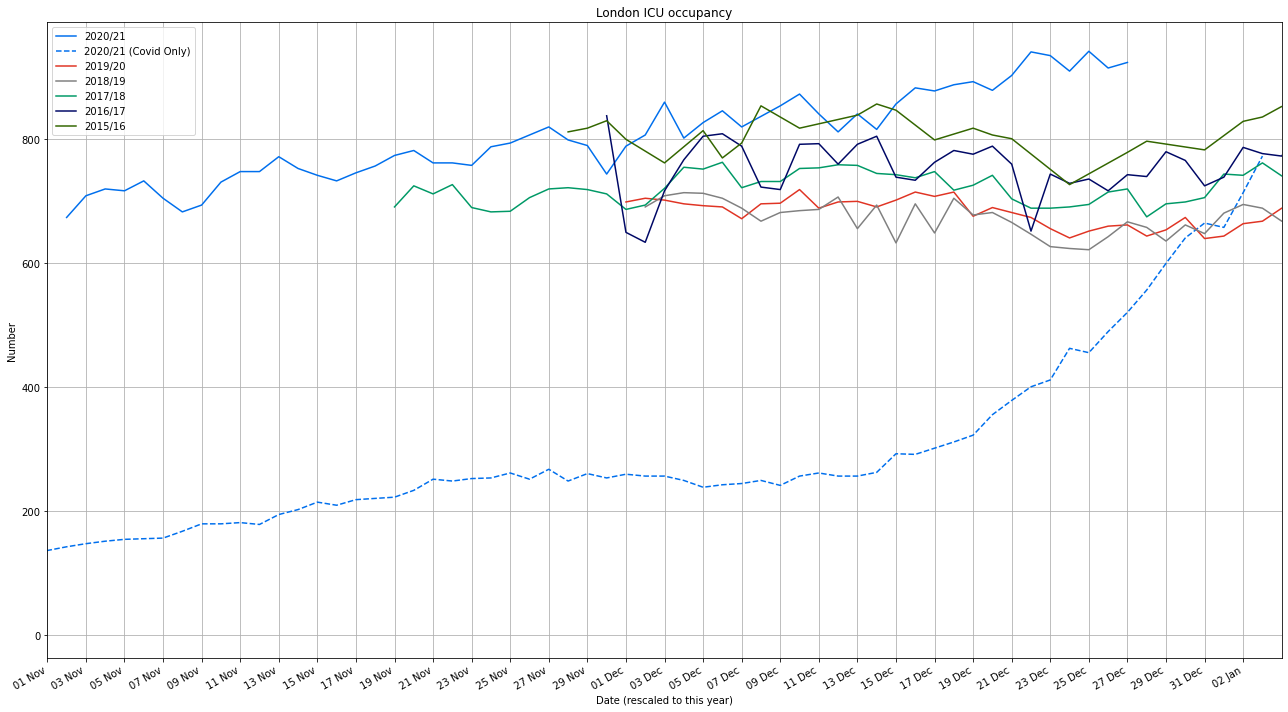

In [24]:
make_plot('London', plot_covid_only=True)

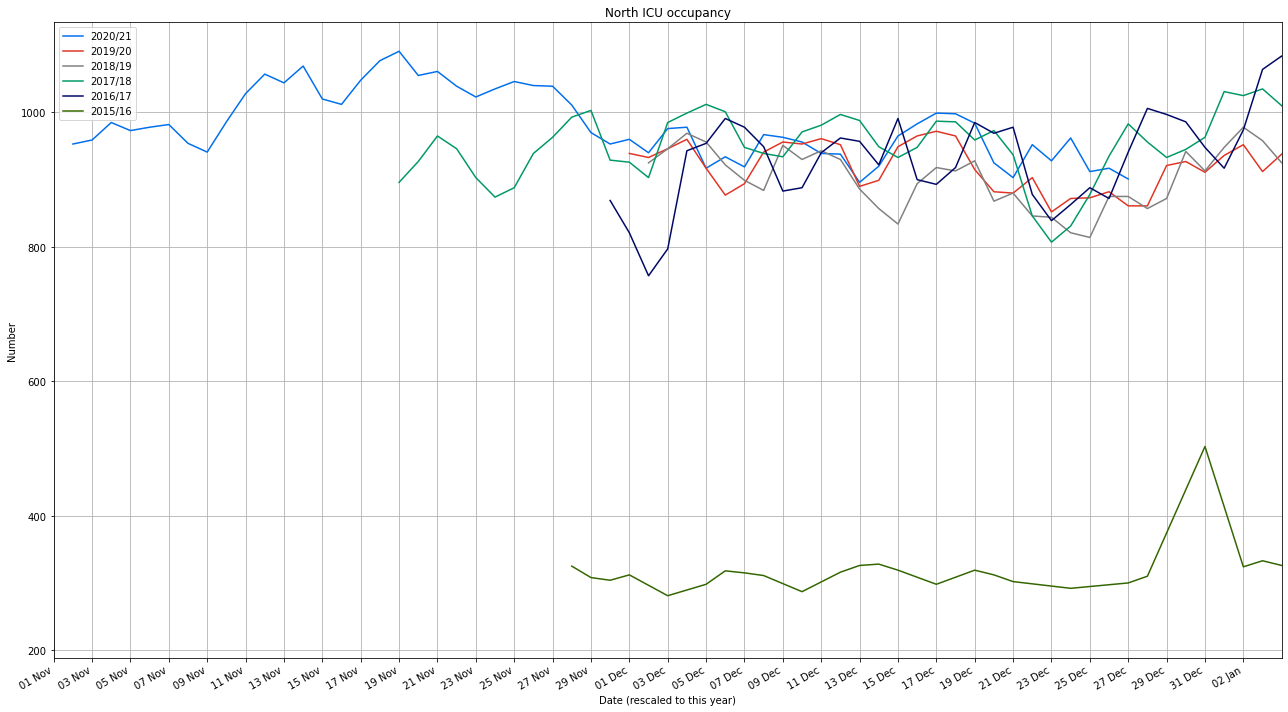

In [25]:
make_plot('North')

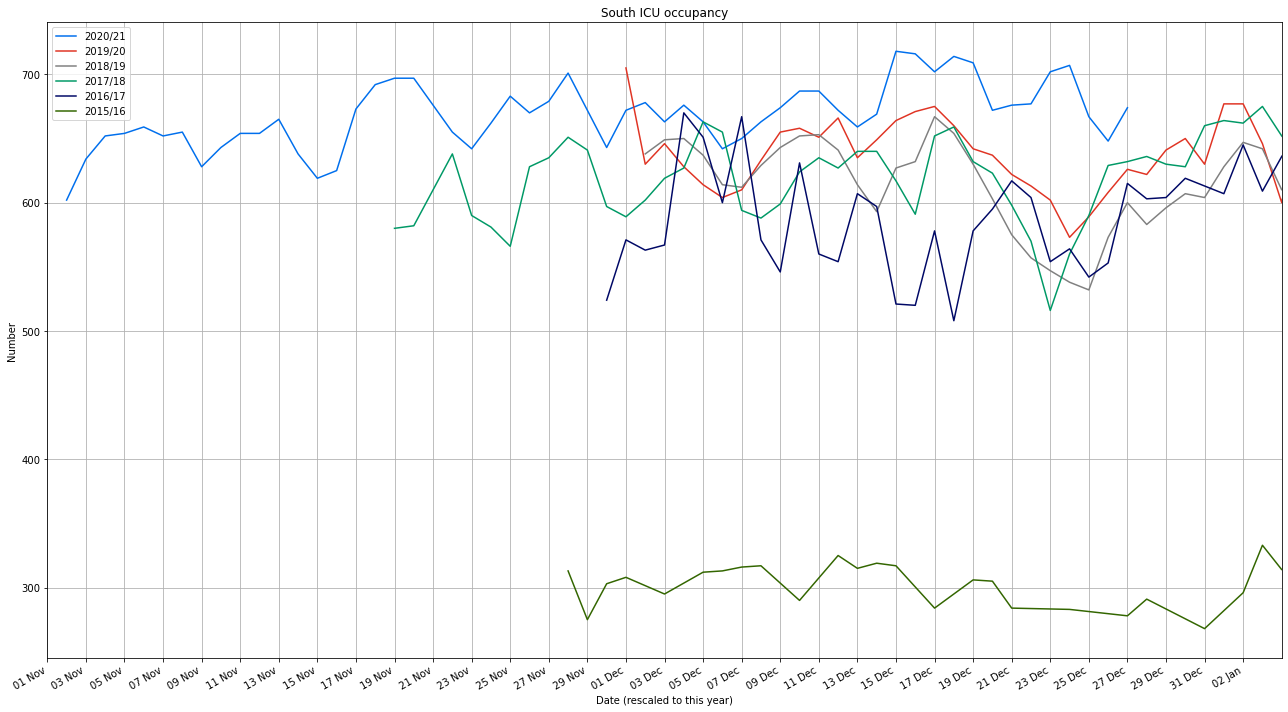

In [26]:
make_plot('South')

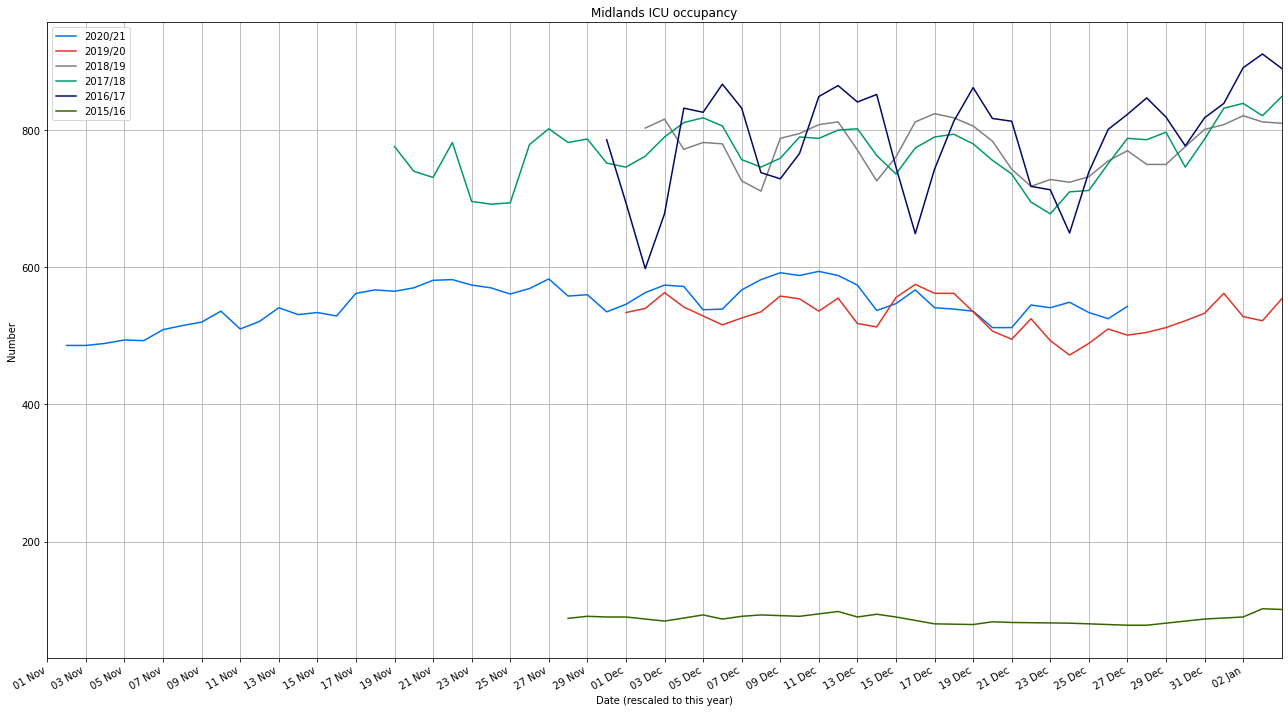

In [27]:
make_plot('Midlands')